# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


**Описание данных**

Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

*Целевой признак*
* Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


Изучим предоставленные данные: выведем информацию о датасете, первые пять строк и статистические данные.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head()  

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Итого:**

1. В исходном файле данные о 10000 клиентах, информация о которых разбита на 14 столбцов.
2. В дальнейшем нам понадобятся не все столбцы. Можно удалить столбцы с индексом строки данных,  фамилией, уникальным идентификатором клиента, т к исследование обезличено.
3. Переведем названия столбцов в нижний регистр.

In [5]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
data.shape

(10000, 11)

In [6]:
data.columns = data.columns.str.lower()

In [7]:
print("Количесвто дубликатов:", data.duplicated().sum())

print('Делим столбцы по типу данных на 2 группы:')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
objects = ['object']
newdf = data.select_dtypes(include=numerics)
newdf_object = data.select_dtypes(include=objects)
numeric_columns = newdf.columns[:-1]
numeric_columns



Количесвто дубликатов: 0
Делим столбцы по типу данных на 2 группы:


Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary'],
      dtype='object')

Выводим информацию о пропусках:

In [8]:
data.isna().sum()

creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [9]:
print('Процент пропусков в столбце tenure:',( data['tenure'].isna().sum()*100)/len(data), '%')


Процент пропусков в столбце tenure: 9.09 %


Выводим уникальные значения по столбцам:

In [10]:
def check_columns(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
        
check_columns(data)

Уникальные значения столбца creditscore
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 80

**Итого:**

1. Клиентами банка являются граждане Франции, Испани и Германии. 
2. Максимальное количество продуктов банка на одного клиента - 4.
3. В столбце с информацией о количестве лет, в течение которых человек является клиентом банка, присутствуют 9% пропусков и нулевые значения.
3. Среди прочих значений нелогичных нет.


**Создадим датафрейм по методу прямого кодирования с защитой от дамми-ловушки.**

In [11]:
df = pd.get_dummies(data, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             9091 non-null   float64
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  int64  
 6   isactivemember     10000 non-null  int64  
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


**Обработка пропусков**
<br>В столбце с информацией о количестве лет, в течение которых человек является клиентом банка, присутствуют пропуски и нулевые значения в значительном количестве. Можно предположить, что за этим скрываются клиенты, пользующиеся услугами банка меньше года и заменить пропуски в этом столбце на "0". Но так же возможно, что это пропуски-недочеты и их можно либо удалить, либо заполнить медианным или случайным значением. А еще можно пойти по сложному пути и сделать все три варианта. Однако в таком случае вырастает риск ошибиться в груде однотипных расчетов, что отнимет время и создаст риск ложного результата при неявной ошибке.

Заполним пропуски нулевыми значениями исходя из гепотезы о том, что это новые клиенты банка:

In [12]:
df['tenure'] = df['tenure'].fillna(0) 
print(f"Количество пропусков в  df: {df['tenure'].isna().sum()}")                                                                                 

Количество пропусков в  df: 0


In [13]:
print('Процент нулевых значений в столбце tenure:', (len(df[df['tenure']== 0])*100)/len(df), '%')

Процент нулевых значений в столбце tenure: 12.91 %


На основании чего можно принять такой вариант за действительный, т к процент достаточно низок. 

## Исследование задачи

Используем следующие модели:

* логистическая регрессия;
* метод случайного леса;
* метод дерева решений;
* GaussianNB.






**Формируем выборки.**

<br>Разобъем данные по принципу 3:1:1.
<br>Разделим выборку на тренировочную и валидационную c учетом целевого признака *exited*. 

In [14]:
def split_df(features, target):
    (features_train, features_valid,
     target_train, target_valid) = train_test_split(features, target, test_size = 0.33, random_state = 12345)
    (features_test, features_valid, 
     target_test, target_valid) = train_test_split(features_valid, target_valid, test_size = 0.5, random_state = 12345)
    
    return (features_train, features_valid, features_test, target_train, target_valid, target_test)

In [15]:
target = df['exited']
features = df.drop('exited', axis=1)


In [16]:
(features_train, features_valid, features_test,
 target_train, target_valid, target_test) = split_df(df.drop(["exited"], axis = 1), df["exited"])


**Выполняем маштабирование**

In [17]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])


**Баланс классов**

In [18]:
balance_rate_df = list(target_train.value_counts(normalize=True))
print("Баланс классов: ", balance_rate_df)

Баланс классов:  [0.7991044776119403, 0.2008955223880597]


Баланс классов: 79% отрицательного класса и 21% положительного, т е  4:1.

*Изучим модели без исправление баланса.*

**Модель "Дерево решений"**


Проведем исследование при разном значении max_depth.


In [19]:
%%time
best_depth = None 
best_result_three = 0

for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=20052020, max_depth=depth)
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Max depth', depth,'F1-score', result)
    
    if result > best_result_three:
        best_depth = depth
        best_result_three = result
 
print()
print('При max_depth = ', best_depth, 'лучший результат: ', best_result_three, end='\n\n')

Max depth 1 F1-score 0.0
Max depth 2 F1-score 0.49498327759197325
Max depth 3 F1-score 0.43749999999999994
Max depth 4 F1-score 0.4653061224489797
Max depth 5 F1-score 0.5493716337522442
Max depth 6 F1-score 0.5214007782101168
Max depth 7 F1-score 0.520754716981132
Max depth 8 F1-score 0.5029239766081871
Max depth 9 F1-score 0.5484460694698354
Max depth 10 F1-score 0.5680672268907564
Max depth 11 F1-score 0.5186440677966102
Max depth 12 F1-score 0.49751243781094534
Max depth 13 F1-score 0.5194401244167962
Max depth 14 F1-score 0.49768160741885625
Max depth 15 F1-score 0.47806354009077157
Max depth 16 F1-score 0.49016641452344933
Max depth 17 F1-score 0.47819548872180445
Max depth 18 F1-score 0.4801178203240059
Max depth 19 F1-score 0.4738372093023256

При max_depth =  10 лучший результат:  0.5680672268907564

CPU times: user 724 ms, sys: 8.69 ms, total: 733 ms
Wall time: 761 ms


**Модель "Случайный лес"**

Проведем исследование на разное количество деревьев.

In [20]:
%%time
best_estimator = None 
best_result_forest = 0

for estimator in range(1, 100, 5):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('При N estimators = ', estimator,', F1 =', result )
    
    if result > best_result_forest:
        best_estimator = estimator
        best_result_forest = result
 
print()
print('При N estimators = ', estimator, 'лучший результат: ', best_result_forest, end='\n\n')

При N estimators =  1 , F1 = 0.46888567293777134
При N estimators =  6 , F1 = 0.4915572232645404
При N estimators =  11 , F1 = 0.5201465201465202
При N estimators =  16 , F1 = 0.5171102661596959
При N estimators =  21 , F1 = 0.5563636363636364
При N estimators =  26 , F1 = 0.5363128491620112
При N estimators =  31 , F1 = 0.5547445255474452
При N estimators =  36 , F1 = 0.5434380776340112
При N estimators =  41 , F1 = 0.5621621621621621
При N estimators =  46 , F1 = 0.5557586837294333
При N estimators =  51 , F1 = 0.554954954954955
При N estimators =  56 , F1 = 0.5500910746812386
При N estimators =  61 , F1 = 0.5615942028985508
При N estimators =  66 , F1 = 0.5583941605839416
При N estimators =  71 , F1 = 0.5615942028985508
При N estimators =  76 , F1 = 0.5547445255474452
При N estimators =  81 , F1 = 0.5667870036101083
При N estimators =  86 , F1 = 0.56
При N estimators =  91 , F1 = 0.5652173913043479
При N estimators =  96 , F1 = 0.5610200364298725

При N estimators =  96 лучший резул

Используем параметры дерева решений:

In [21]:
%%time
best_estimator_2 = None 
best_result_forest_2 = 0

for estimator in range(41, 100, 2):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result= f1_score(target_valid, predicted_valid)
    print('При N estimators =', estimator,'F1 = ', result)
    
    if result > best_result_forest_2:
        best_estimator_2 = estimator
        best_result_forest_2 = result
 
print()
print('При max_depth = ', estimator, 'лучший результат: ', best_result_forest_2, end='\n\n')

При N estimators = 41 F1 =  0.5621621621621621
При N estimators = 43 F1 =  0.5641952983725135
При N estimators = 45 F1 =  0.5631768953068592
При N estimators = 47 F1 =  0.5555555555555555
При N estimators = 49 F1 =  0.5585585585585585
При N estimators = 51 F1 =  0.554954954954955
При N estimators = 53 F1 =  0.5595667870036102
При N estimators = 55 F1 =  0.5637342908438061
При N estimators = 57 F1 =  0.5637342908438061
При N estimators = 59 F1 =  0.5543478260869565
При N estimators = 61 F1 =  0.5615942028985508
При N estimators = 63 F1 =  0.558983666061706
При N estimators = 65 F1 =  0.5626134301270417
При N estimators = 67 F1 =  0.5626134301270417
При N estimators = 69 F1 =  0.5641952983725135
При N estimators = 71 F1 =  0.5615942028985508
При N estimators = 73 F1 =  0.5605786618444846
При N estimators = 75 F1 =  0.5605786618444846
При N estimators = 77 F1 =  0.5605786618444846
При N estimators = 79 F1 =  0.5615942028985508
При N estimators = 81 F1 =  0.5667870036101083
При N estimator

**Логистическая регрессия**

In [22]:
%%time

model =  LogisticRegression(random_state=20052020)  #, solver='liblinear'
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid), end='\n\n')

F1 0.2901098901098901

CPU times: user 339 ms, sys: 267 ms, total: 606 ms
Wall time: 560 ms


Получаем довольно низкий результат. Возможно precision или recall низкий и близок к 0.

**GaussianNB.**

In [23]:
%%time

model =  GaussianNB()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid), end='\n\n')


F1 0.40307101727447214

CPU times: user 16.7 ms, sys: 13 µs, total: 16.7 ms
Wall time: 15.8 ms


Так же получаем, низкий результат.

**Проведем оценку accuracy, precision и recall, выведем F-меру.**

In [24]:
model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Дерево решений:')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес:')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия:')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = GaussianNB()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('GaussianNB:')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

Дерево решений:
Accuracy =  0.8460606060606061
Precision =  0.7150259067357513
Recall =  0.4094955489614243
F1 =  0.520754716981132

Случайный лес:
Accuracy =  0.8521212121212122
Precision =  0.7142857142857143
Recall =  0.4599406528189911
F1 =  0.5595667870036102

Логистическая регрессия:
Accuracy =  0.8042424242424242
Precision =  0.559322033898305
Recall =  0.19584569732937684
F1 =  0.2901098901098901

GaussianNB:
Accuracy =  0.8115151515151515
Precision =  0.5706521739130435
Recall =  0.3115727002967359
F1 =  0.40307101727447214



*Построим ROC-кривую для кажддой модели. Выведем показатель AUC-ROC.*

AUC-ROC DecisionTreeClassifier 0.8320560656841762
AUC-ROC RandomForestClassifier 0.8548875544938653
AUC-ROC LogisticRegression 0.7456094159975231
AUC-ROC GaussianNB 0.7636960683057576


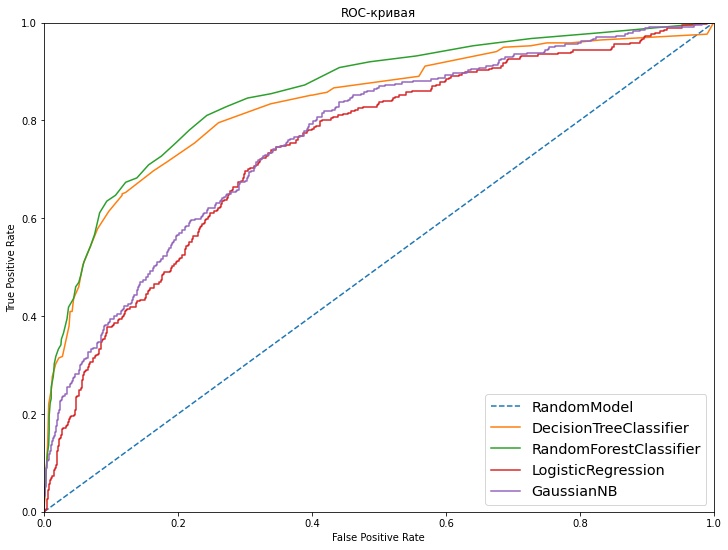

In [25]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = GaussianNB()
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC GaussianNB',auc_roc)
plt.plot(fpr, tpr, label='GaussianNB')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Получаем лучшие показатели  меры f1 и AUC-ROC у модели "случайного леса"

**Вывод по шагу 2**

Обнаружен дисбаланс классов: 79% отрицательного класса и 21% положительного, т е 4:1. Есть вероятность, что он влияет на качество моделей. Из-за этого все модели имеют recall ниже, чем percision, что влияет на F-меру.

После проведенных расчетов лучший результат у "случайного леса"

## Борьба с дисбалансом

Выполним сравнение моделей:

* С взвешенными классами
* С уменьшенной выборкой
* С увеличенной выборкой

**Взвешевание классов:**

In [26]:
model = DecisionTreeClassifier(random_state=20052020, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Дерево решений')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()


Дерево решений
Accuracy =  0.7648484848484849
Precision =  0.4564102564102564
Recall =  0.7922848664688428
F1 =  0.579175704989154

Случайный лес
Accuracy =  0.8484848484848485
Precision =  0.7208121827411168
Recall =  0.42136498516320475
F1 =  0.5318352059925093

Логистическая регрессия
Accuracy =  0.6993939393939393
Precision =  0.3715670436187399
Recall =  0.6824925816023739
F1 =  0.48117154811715485



F-мера стала меньше у дерева решений и случайного леса, но значительно выросла  у логистической регресии.

**Уменьшения значений класса 0.**

In [27]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=20052020)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=20052020)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=20052020)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

1    1346
0    1338
Name: exited, dtype: int64


In [28]:
model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Дерево решений')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = GaussianNB()
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('GaussianNB')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

Дерево решений
Accuracy =  0.7818181818181819
Precision =  0.47704590818363274
Recall =  0.7091988130563798
F1 =  0.5704057279236276

Случайный лес
Accuracy =  0.7866666666666666
Precision =  0.4857685009487666
Recall =  0.7596439169139466
F1 =  0.5925925925925926

Логистическая регрессия
Accuracy =  0.6981818181818182
Precision =  0.37282780410742494
Recall =  0.7002967359050445
F1 =  0.48659793814432994

GaussianNB
Accuracy =  0.7012121212121212
Precision =  0.3704318936877076
Recall =  0.6617210682492581
F1 =  0.4749733759318423



Выросли показатели логистической регрессии и гаусовской модели.

**Методы увеличения класса 1.**

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

1    5384
0    5354
Name: exited, dtype: int64


In [30]:
model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Дерево решений')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

model = GaussianNB()
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('GaussianNB')
print('Accuracy = ', accuracy_score(target_valid, predicted_valid))
print('Precision = ', precision_score(target_valid, predicted_valid))
print('Recall = ', recall_score(target_valid, predicted_valid))
print('F1 = ', f1_score(target_valid, predicted_valid))
print()

Дерево решений
Accuracy =  0.7660606060606061
Precision =  0.45826235093696766
Recall =  0.798219584569733
F1 =  0.5822510822510824

Случайный лес
Accuracy =  0.8515151515151516
Precision =  0.6608391608391608
Recall =  0.5608308605341247
F1 =  0.6067415730337079

Логистическая регрессия
Accuracy =  0.6975757575757576
Precision =  0.3701923076923077
Recall =  0.685459940652819
F1 =  0.4807492195629553

GaussianNB
Accuracy =  0.7006060606060606
Precision =  0.36894824707846413
Recall =  0.655786350148368
F1 =  0.47222222222222227



F-мера выросла у случайного леса, логистической регресии и гаусовской модели по сравнению с дисбалансными данными. Лучшей моделью по F-мере стал случайный лес с тренировочными данными с увеличением класса 1.

*Выведем ROC-кривую и AUC-ROC для посленнего измененного баланса.*

AUC-ROC DecisionTreeClassifier 0.840016859480972
AUC-ROC RandomForestClassifier 0.8502794470271041
AUC-ROC LogisticRegression 0.7495146684264408
AUC-ROC GaussianNB 0.7636960683057576


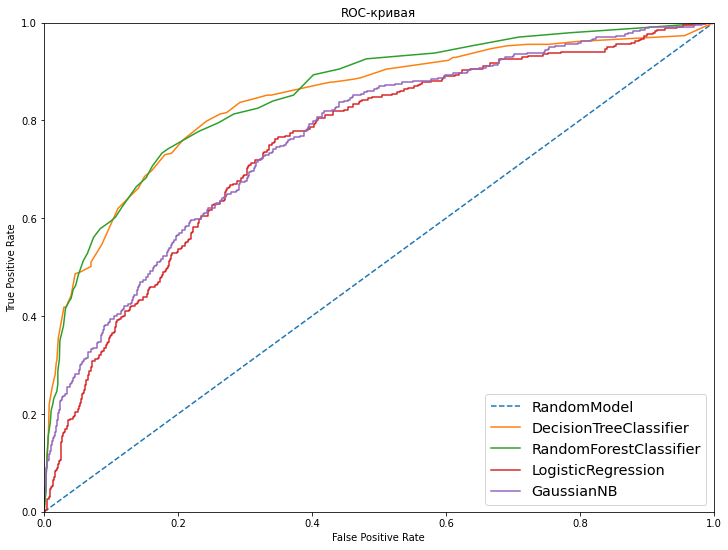

In [31]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = GaussianNB()
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC GaussianNB',auc_roc)
plt.plot(fpr, tpr, label='GaussianNB')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Вывод:**

После устранения дисбаланса стало видно, что он исказил результаты моделей.  По результатам вычислений оптимальным решением  является  увеличение классов 1 в тренировочной выборке.

Утстранение дисбаланса в выборке привело к заметному росту параметра recall и небольшому снижению percison. Но в целом F-мера выросла.


## Тестирование модели

Лучше всего себя показала модель случайного леса. Исследуем гиперпараметры и улучшим F-меру модели.

In [32]:
%%time
best_estimator = None 
best_result_forest = 0

for estimator in range(20, 300, 25):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('При N estimators = ', estimator,', F1 =', result )
    
    if result > best_result_forest:
        best_estimator = estimator
        best_result_forest = result
 
print()
print('При N estimators = ', estimator, 'лучший результат: ', best_result_forest, end='\n\n')

При N estimators =  20 , F1 = 0.5318352059925093
При N estimators =  45 , F1 = 0.5631768953068592
При N estimators =  70 , F1 = 0.558983666061706
При N estimators =  95 , F1 = 0.56
При N estimators =  120 , F1 = 0.5541284403669725
При N estimators =  145 , F1 = 0.5547445255474452
При N estimators =  170 , F1 = 0.5444444444444445
При N estimators =  195 , F1 = 0.5494505494505495
При N estimators =  220 , F1 = 0.5488029465930019
При N estimators =  245 , F1 = 0.5504587155963303
При N estimators =  270 , F1 = 0.5504587155963303
При N estimators =  295 , F1 = 0.5551470588235294

При N estimators =  295 лучший результат:  0.5631768953068592

CPU times: user 23 s, sys: 111 ms, total: 23.1 s
Wall time: 23.7 s


In [33]:
%%time
best_estimator = None 
best_result_forest = 0

for estimator in range(290, 320, 2):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('При N estimators = ', estimator,', F1 =', result )
    
    if result > best_result_forest:
        best_estimator = estimator
        best_result_forest = result
 
print()
print('При N estimators = ', estimator, 'лучший результат: ', best_result_forest, end='\n\n')

При N estimators =  290 , F1 = 0.5471349353049908
При N estimators =  292 , F1 = 0.5498154981549814
При N estimators =  294 , F1 = 0.5524861878453039
При N estimators =  296 , F1 = 0.5524861878453039
При N estimators =  298 , F1 = 0.5551470588235294
При N estimators =  300 , F1 = 0.5577981651376147
При N estimators =  302 , F1 = 0.5535055350553505
При N estimators =  304 , F1 = 0.5508317929759704
При N estimators =  306 , F1 = 0.5535055350553505
При N estimators =  308 , F1 = 0.5535055350553505
При N estimators =  310 , F1 = 0.5524861878453039
При N estimators =  312 , F1 = 0.5524861878453039
При N estimators =  314 , F1 = 0.5514705882352942
При N estimators =  316 , F1 = 0.5514705882352942
При N estimators =  318 , F1 = 0.5514705882352942

При N estimators =  318 лучший результат:  0.5577981651376147

CPU times: user 54.8 s, sys: 155 ms, total: 55 s
Wall time: 55.4 s


In [34]:
print('Проверяем:')
model =  RandomForestClassifier(random_state=20052020, n_estimators=387, criterion='entropy')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

Проверяем:
F1 0.61198738170347


*Изменим гиперпараметр min_samples_split.*

In [35]:
split_result = 0
sample_split_best = None

for samples_split in range(1, 11):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=samples_split/10)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Samples_split =', samples_split/10,'F1 =', result )
    
    if  result >  split_result:
        split_result = result
        sample_split_best = samples_split
print()         
print('При sample_split = ', sample_split_best, 'лучший результат =',  split_result)    
print()    
    
splits_result = 0
samples_split_best = None

for samples_split in range(2, 11):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=samples_split)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Samples_split = ', samples_split,'F1 = ', f1_score(target_valid, predicted_valid))
    
    if  result >  splits_result:
        splits_result = result
        samples_split_best = samples_split
print()         
print('При samples_split = ', samples_split_best, 'лучший результат =', splits_result)  

Samples_split = 0.1 F1 = 0.5720876585928489
Samples_split = 0.2 F1 = 0.549618320610687
Samples_split = 0.3 F1 = 0.5236593059936908
Samples_split = 0.4 F1 = 0.5200845665961945
Samples_split = 0.5 F1 = 0.5350877192982456
Samples_split = 0.6 F1 = 0.5197368421052632
Samples_split = 0.7 F1 = 0.3392048314041268
Samples_split = 0.8 F1 = 0.3392048314041268
Samples_split = 0.9 F1 = 0.3392048314041268
Samples_split = 1.0 F1 = 0.3392048314041268

При sample_split =  1 лучший результат = 0.5720876585928489

Samples_split =  2 F1 =  0.6025641025641025
Samples_split =  3 F1 =  0.6060606060606061
Samples_split =  4 F1 =  0.6006389776357828
Samples_split =  5 F1 =  0.6190476190476191
Samples_split =  6 F1 =  0.6335403726708075
Samples_split =  7 F1 =  0.6099071207430341
Samples_split =  8 F1 =  0.6158536585365854
Samples_split =  9 F1 =  0.6251896813353566
Samples_split =  10 F1 =  0.6144578313253012

При samples_split =  6 лучший результат = 0.6335403726708075


*Изменим гиперпараметр min_samples_leaf.*

In [36]:
leaf_result = 0
samples_leaf_best = None


for samples_leaf in range(1, 5):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5, 
                                    min_samples_leaf= samples_leaf/10)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result= f1_score(target_valid, predicted_valid)
    print('Samples_leaf', samples_leaf/10,'F1', result)
    
    if  result >  leaf_result:
        leaf_result = result
        sample_leaf_best = samples_leaf
print()         
print('При sample_leaf = ', sample_leaf_best, 'лучший результат =',  leaf_result)    
print()  
    
leafs_result = 0
samples_leafs_best = None    
    
for samples_leafs in range(1, 11):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf= samples_leafs)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result=f1_score(target_valid, predicted_valid)
    print('Samples_leaf = ', samples_leaf,'F1', result)
    
    if  result >  leaf_result:
        leafs_result = result
        sample_leafs_best = samples_leafs
        
print()         
print('При sample_leafs = ', sample_leafs_best, 'лучший результат =',  leafs_result)    
print()

Samples_leaf 0.1 F1 0.5184404636459431
Samples_leaf 0.2 F1 0.509719222462203
Samples_leaf 0.3 F1 0.4721951219512195
Samples_leaf 0.4 F1 0.3392048314041268

При sample_leaf =  1 лучший результат = 0.5184404636459431

Samples_leaf =  4 F1 0.6190476190476191
Samples_leaf =  4 F1 0.6253776435045317
Samples_leaf =  4 F1 0.6202898550724638
Samples_leaf =  4 F1 0.6184397163120567
Samples_leaf =  4 F1 0.6210670314637483
Samples_leaf =  4 F1 0.6174496644295302
Samples_leaf =  4 F1 0.6196808510638298
Samples_leaf =  4 F1 0.6174142480211082
Samples_leaf =  4 F1 0.6240208877284595
Samples_leaf =  4 F1 0.6141935483870968

При sample_leafs =  10 лучший результат = 0.6141935483870968



**Проверим на тестовой выборке четыре модели: на дисбалансных данных и сбалансированных: со взвешенными классами, усечением 0 класса и расширением класса 1.**

In [37]:
model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=6,
                                   min_samples_leaf=10)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Случайный лес - дисбаланс классов')
print('Accuracy = ', accuracy_score(target_test, predicted_test))
print('Precision = ', precision_score(target_test, predicted_test))
print('Recall = ', recall_score(target_test, predicted_test))
print('F1 = ', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=6,
                                   min_samples_leaf=10, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Случайный лес - взвешенные классы')
print('Accuracy = ', accuracy_score(target_test, predicted_test))
print('Precision = ', precision_score(target_test, predicted_test))
print('Recall = ', recall_score(target_test, predicted_test))
print('F1 = ', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=6,
                                   min_samples_leaf=10)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print('Случайный лес - уменьшенное количество классов 0')
print('Accuracy = ', accuracy_score(target_test, predicted_test))
print('Precision = ', precision_score(target_test, predicted_test))
print('Recall = ', recall_score(target_test, predicted_test))
print('F1 = ', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=6,
                                   min_samples_leaf=10)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('Случайный лес - увеличенное количество классов 1')
print('accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

Случайный лес - дисбаланс классов
Accuracy =  0.8587878787878788
Precision =  0.8342541436464088
Recall =  0.4265536723163842
F1 =  0.5644859813084112

Случайный лес - взвешенные классы
Accuracy =  0.8315151515151515
Precision =  0.5931372549019608
Recall =  0.6836158192090396
F1 =  0.6351706036745408

Случайный лес - уменьшенное количество классов 0
Accuracy =  0.7903030303030303
Precision =  0.5075757575757576
Recall =  0.7570621468926554
F1 =  0.6077097505668934

Случайный лес - увеличенное количество классов 1
accuracy 0.8187878787878788
Precision 0.5641025641025641
Recall 0.6836158192090396
F1 0.6181353767560664



AUC-ROC RandomForestClassifier - disbalanced 0.8569435725744576
AUC-ROC RandomForestClassifier - balanced by class weight 0.8548380065564622
AUC-ROC RandomForestClassifier - balanced by reduce 0 class 0.8569828067238613
AUC-ROC RandomForestClassifier - balanced by grow 1 class 0.8512633396107973


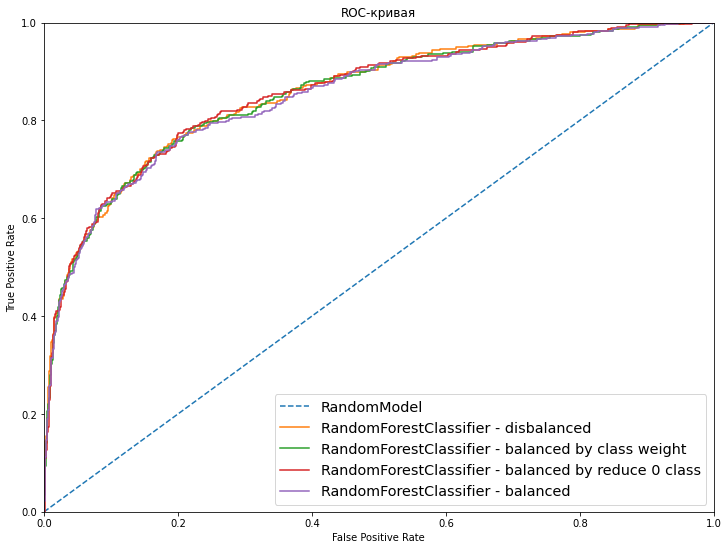

In [38]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - disbalanced',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - disbalanced')

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by class weight',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by class weight')

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by reduce 0 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by reduce 0 class')

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by grow 1 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Вывод по пункту 4**

3 из 4 моделей достигли минимума F-меры на тестовых данных: модель случайного леса со взвешенными весами классов и моделb с увеличенным  количеством класса 1 и уменьшенным количеством класса 0.

Лучший результат даёт взвешивание классов. Percision падает, recall растет, и в целом F-мера имеет небольшой прирост. Баланс классов повышает охват необходимых данных. Так же, по кривой AUC-ROC у AUC-ROC дисбалансной модели и модели с весами видно, что они примерно одинаково предсказывают вероятность ухода клиента.

В результате исследования была получена модель с лучшими показателями как по F1-мере, так и по AUC-ROC - Случайный лес: взвешенные классы.



## Итоговый вывод

При работе с проектом: были изучены предоставленные данные, выполнена предобработка, заполнены пропуски и произведена оценка данных. Далее, датасет был разбит на  тренировочную, валидационную и тестовую выборки. Выполнено маштабирование, оценен баланс данных. Была выполнена проверка данных без изменений на выбранных моделях. Далее был устранен дисбаланс в данных и сформированы модели(на дисбалансных данных и сбалансированных: со взвешенными классами, усечением 0 класса и расширением класса 1) с целью работы с тествовой выборкой. По результатам работы были выделены наиболее успешные модели, результат работы которых отвечал заданному условию(F1-метрика >  0.59). Наилучший результат показала модель случайного леса со взвешенными весами классов, она имеет достаточную адекватность с результатом AUC-ROC = 0.861 при AUC-ROC = 0.5 в случайной модели. Аccuracy модели 0.8315, precision 0.593, recall 0.683 и f1 0.635. Модель старается собрать больше данных, чем показать верную точность (recall > precision). Процент попадания в классы достаточно высокий.
